In [16]:
!pip install opencv-python pixellib


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


원본 고양이 이미지 크기: (1667, 2500, 3)
배경(사막) 이미지 크기: (797, 1200, 3)


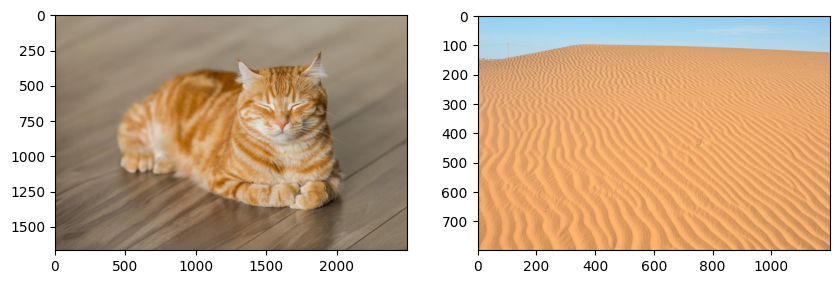

In [69]:
cat_img_path = "cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "sand.jpg"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [19]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [20]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (1667, 2500)


In [21]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


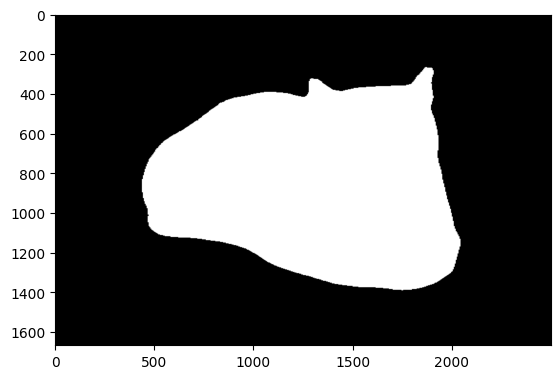

In [22]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

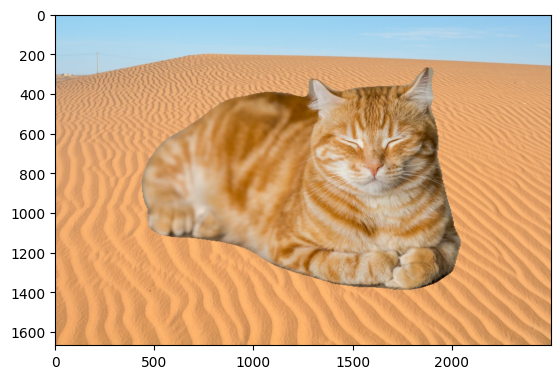

In [23]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

## Foreground Oject를 명확하게 인식못해서 사람과 사물이 겹쳐서 나오는현상..

### 문제점
- Semantic Segmentation은 "이 픽셀이 사람 카테고리에 속하는가?"만 따지기 때문에, 사람 주변의 물체나 배경 일부를 사람으로 뭉뚱그려 잡는 경우가 많습니다. 특히 경계선이 뭉툭하게 표현됩니다.
- 인공지능이 눈으로 그림을 보고 "어? 저건 사람 색깔이네? 저 모양은 옷이네?" 하고 색칠 공부를 하는 것입니다.잠바가 사람 뒤에 있는지, 옆에 있는지 모릅니다
- 그냥 "사람 색깔이니까 사람!"이라고 뭉뚱그려 색칠해 버립니다. 그래서 아까 잠바가 계속 붙어 았습니다.

###  해결책
- 광학적 방식 (Real Depth): 실제 카메라 렌즈는 빛의 물리학을 이용해 "거리가 1m인 것만 선명하게, 나머진 흐리게" 만듭니다
- "색칠 공부(Semantic)"의 부정확함에 질려서, "거리(Depth)로 자르는 방식".
- MiDaS 모델: 2D 사진에서 가상의 거리(Depth Map)를 뽑아내는 역할을 했습니다.
- DPT (Dense Prediction Transformer)
  - **Transformer(트랜스포머)라는 단어가 핵심
  - 과거 방식 (CNN): 사진의 픽셀을 좁은 범위에서 조금씩 훑으며 특징을 찾았습니다. 그래서 "멀리 있는 배경"과 "가까운 사람" 사이의 관계를 파악하는 능력이 좀 부족했습니다.
  - DPT 방식 (Transformer): 챗GPT가 문장 전체의 맥락을 읽듯, 사진 전체의 맥락을 한꺼번에 분석합니다.
- rembg로 정교하게 자른다.


In [76]:
!pip install "numpy<2.4" "rembg[cpu]" onnxruntime

!pip install timm


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [77]:
import cv2
import numpy as np
import torch
from rembg import remove, new_session
import matplotlib.pyplot as plt


if 'midas' not in globals():
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    midas.to(device).eval() # 모델의 모드를 '실전'으로

    # 사이즈 맞춤 (Resizing): 사진이 너무 크면 줄이고, 작으면 키워서 모델이 가장 좋아하는 해상도(예: 384x384)로 딱 맞춥니다.
    # 색상 보정 (Normalization): 사진의 밝기나 색감을 모델이 기억하는 표준값으로 정밀하게 조정합니다. (그래야 거리를 정확히 잽니다.)
    # 포장 (To Tensor): 파이썬의 일반 이미지를 인공지능이 계산할 수 있는 '수학적 덩어리(Tensor)'로 포장합니다.
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

In [78]:
def get_clean_foreground(img_path, model, transform, device):
    """
    모든 리소스를 파라미터로 받아, 가장 앞쪽의 거대한 덩어리 하나만 추출.
    (이 과정에서 잠바와 노이즈가 사라집니다)
    """
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # [Depth 분석]
    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        prediction = model(input_batch) # Depth Map 384x384

        # 복원 원래 크기대로...
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1), # interpolate라는 함수는 아주 까다로워서, 데이터가 4차원이어야만 받아줍니다. (예: [1개, 1채널, 가로, 세로]). 우리 데이터에 "가짜 차원" 하나를 억지로 끼워 넣는 과정입니다.
            size=img_rgb.shape[:2], # size=img_rgb.shape[:2]: "우리 원래 사진의 가로, 세로 크기로 확 늘려줘!"라는 목표치를 정해줍니다.
            mode="bicubic", #  이미지를 늘릴 때 그냥 늘리면 계단처럼 깨집니다. 이걸 아주 부드럽게(포토샵 효과처럼) 보정하며 늘리라는 정밀 옵션
            align_corners=False # 억지로 끼워 넣었던 "가짜 차원"은 이제 필요 없으니 다시 쏙 빼버립니다.
        ).squeeze()
    
    depth_map = prediction.cpu().numpy() #numpy형식으로...
    
    # [필터링] 전체 거리 데이터 중에서 멀리 있는 66%는 검게 지우고, 가깝게 있는 앞쪽 34%만 하얗게 남겨서 나중에 오려낼 준비"
    mask = (depth_map > np.percentile(depth_map, 66)).astype(np.uint8) * 255
        
    return cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

In [79]:
def synthesize_desert(fg_path, bg_path, model, transform, device):

    fg_img = get_clean_foreground(fg_path, model, transform, device)
    session = new_session("u2net")
   

    # 배경 로드 및 합성
    # 정교하게 자른다...
    # clean_rgba는 **"사람 컬러 정보(RGB)"에 "정밀한 투명도 정보(Alpha)"가 한데 모인 4채널 이미지 데이터입니다.
    clean_rgba = remove(fg_img, session=session, alpha_matting=False)
    
    #background이미지를 forge ground미지지 크기에 맞게...
    bg_img = cv2.resize(cv2.imread(bg_path), (fg_img.shape[1], fg_img.shape[0]))
    
    # clean_rgba[:, :, 3]: 4번째 채널(Alpha)만 쏙 뽑아옵니다.
    # / 255.0: "점수"를 "비율"로 바꿉니다.
    # 255점(완전 불투명)은 1.0이 되고, 0점(완전 투명)은 0.0이 됩니다.
    # np.expand_dims(..., axis=2):
    # 마스크는 원래 평면(가로x세로)인데, 컬러 사진은 3층(R, G, B)입니다.
     # 이 비율을 R, G, B 세 층에 모두 똑같이 곱해주기 위해 차원을 하나 더 늘려주는(3D로 만드는) 작업입니다.
    alpha = np.expand_dims(clean_rgba[:, :, 3] / 255.0, axis=2)
    

    # "알파 블렌딩(Alpha Blending)"이라는 전 세계 이미지 편집 프로그램(포토샵 등)의 공용 공식입니다.

    # clean_rgba[:, :, :3] * alpha: "사람 컬러 사진에 사람 비율(1.0)을 곱해라." -> 사람은 그대로 남습니다.
    # bg_img * (1 - alpha): "배경 사진에 배경 비율(0.0)을 곱해라." -> 사람 자리는 배경이 0이 되어 사라지고, 사람이 없는 곳(1-0=1)만 배경이 남습니다.
    # 두 개를 더하기(+): 사람 사진과 구멍 뚫린 배경 사진을 합칩니다.
    # .astype(np.uint8): 계산 과정에서 소수점이 생겼으므로, 다시 이미지가 읽을 수 있는 0~255 정수 형태로 깔끔하게 포장합니다.
    res = (clean_rgba[:, :, :3] * alpha + bg_img * (1 - alpha)).astype(np.uint8)

    
    return cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

합성 작업 중...


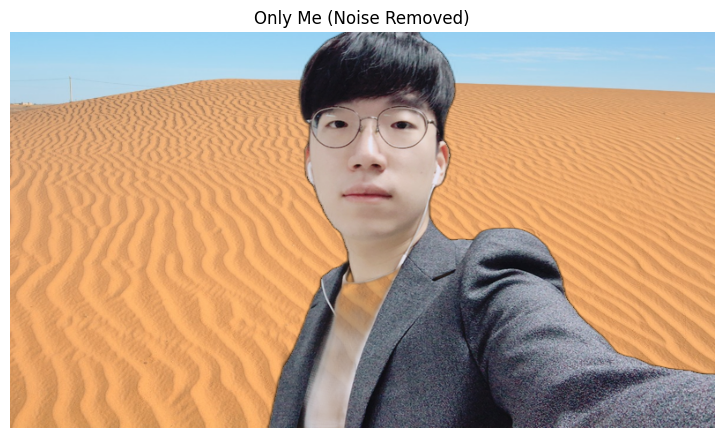

In [80]:
path_sand = "sand.jpg"
path_me = "human_segmentation/images/my_image.png"

try:
    print("합성 작업 중...")
    res_me = synthesize_desert(path_me, path_sand, midas, midas_transforms, device)


    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1); plt.imshow(res_me); plt.title("Only Me (Noise Removed)"); plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error: {e}")

- 이번 프로젝트를 하면서 느낀점, 배운점 
  - 세그멘테이션과, 거리를 측정해서 forground이미지를 얻게되는법을 알게되어서 좋았다..
- 이번 프로젝트에서 잘 했다고 생각이 드는 점.
  - 가상의 거리(Depth Map)를 뽑아내는 방법을써서 깔끔하게 forground를 가져왔다..
- 이번 프로젝트에서 느낀 문제점.
  - 완벽하게 forground를 뽑지는못했다..왼쪽 이어폰이 사라졌음.
  - depth를 이용해서 구분하는경우 이게 이미지가 블러가되어있으면, 블러된부분은 백그라운드로 인식해서 가져오지 못함.
- 다음에는 이렇게 해야겠다 생각한 점.
  - forground이미지에 블러처리
  - jpg뿐만 아니라 아주 고해상도 이미지는 처리가 안되었은데, 처리가능하게 만들어야겠다..